<a href="https://colab.research.google.com/github/ashishthomaschempolil/Neural-Machine-Translation-Italian-to-English/blob/master/italian_to_english_simple_encoder_decoder_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[dataset](http://www.manythings.org/anki/ita-eng.zip)

In [17]:
!pip install -qq wandb

     |████████████████████████████████| 1.8MB 8.1MB/s 
     |████████████████████████████████| 102kB 12.1MB/s 
     |████████████████████████████████| 174kB 50.0MB/s 
     |████████████████████████████████| 133kB 51.9MB/s 
     |████████████████████████████████| 71kB 11.2MB/s 


In [18]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(palette='muted',style='whitegrid')
import re
from multiprocessing import Process# this is used for multithreading
import multiprocessing
import tensorflow as tf
tf.compat.v1.enable_eager_execution()
from tensorflow.keras.layers import TimeDistributed
tf.keras.backend.clear_session()
from tensorflow.keras.layers import Input, Softmax, RNN, Dense, Embedding, LSTM,Dot
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
import numpy as np
import keras.backend as K
import nltk.translate.bleu_score as bleu
import os
import wandb
from wandb.keras import WandbCallback

<font color='blue'>**Load the data**</font>

In [2]:
!curl --header 'Host: www.manythings.org' --user-agent 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10.15; rv:89.0) Gecko/20100101 Firefox/89.0' --header 'Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8' --header 'Accept-Language: en-US,en;q=0.5' --referer 'https://colab.research.google.com/' --header 'DNT: 1' --header 'Upgrade-Insecure-Requests: 1' 'http://www.manythings.org/anki/ita-eng.zip' --output 'ita-eng.zip'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 7466k  100 7466k    0     0  6453k      0  0:00:01  0:00:01 --:--:-- 6453k


In [3]:
!unzip -qq '/content/ita-eng.zip'

In [4]:
filepath = './ita.txt'
f = open(filepath,'r',encoding="utf8")
lines = f.readlines()
total = len(lines) #340432
print("Sample text:\n")
print(lines[-1],'\n','*'*100,'\n')
print("The total no. of datapoints:",total)
f.close()

Sample text:

Doubtless there exists in this world precisely the right woman for any given man to marry and vice versa; but when you consider that a human being has the opportunity of being acquainted with only a few hundred people, and out of the few hundred that there are but a dozen or less whom he knows intimately, and out of the dozen, one or two friends at most, it will easily be seen, when we remember the number of millions who inhabit this world, that probably, since the earth was created, the right man has never yet met the right woman.	Senza dubbio esiste in questo mondo proprio la donna giusta per ogni uomo da sposare e viceversa; ma se si considera che un essere umano ha l'opportunità di conoscere solo poche centinaia di persone, e fra le poche centinaia che ce ne sono solo una dozzina o meno che conosce intimamente e fra la dozzina, uno o due amici al massimo, si vedrà facilmente, quando ricorderemo il numero di milioni che abitano questo mondo, che probabilmente, da quand

<font color='blue'>**Preprocess data**</font>

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
filepath = '/content/drive/My Drive/italian_to_english_simple/'

In [9]:
%%time
# https://stackoverflow.com/a/47091490/4084039
def decontracted(phrase): 
    """Expanding English language contractions in Python"""
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase


def preprocess(start,end,label):
    """
    preprocess the data from start to end that is given and saves it to label.pkl
    if end is False assumes till the end of the list
    """
    
    if end:
        df = pd.DataFrame(columns=['italian','english'])
        with open(filepath,'r',encoding="utf8") as f:
            italian = np.array([])
            english = np.array([])
            for l in f.readlines()[start:end]:
                line = re.sub('CC.*',"",l) #removing all characters after the start of word CC 
                line = re.sub('\t',"_",line) #to differentiate between italian and english.
                k = line.split('_') #1st will be english and 2nd will be italian of the word
                english = np.append(english,decontracted(k[0]).strip().lower()) ##expanding english language contractions and remove trailing spaces and lower all characters
                italian = np.append(italian,k[1].strip().lower())
        df['italian'] = italian
        df['english'] = english
    else:
        df = pd.DataFrame(columns=['italian','english'])
        with open(filepath,'r',encoding="utf8") as f:
            italian = np.array([])
            english = np.array([])
            for l in f.readlines()[start:]:
                line = re.sub('CC.*',"",l) #removing all characters after the start of word CC 
                line = re.sub('\t',"_",line) #to differentiate between italian and english.
                k = line.split('_') #1st will be english and 2nd will be italian of the word
                english = np.append(english,decontracted(k[0]).strip().lower()) ##expanding english language contractions and remove trailing spaces and lower all characters
                italian = np.append(italian,k[1].strip().lower())
        df['italian'] = italian
        df['english'] = english
    df.to_pickle(label+'.pkl')

def process1():
    """
    first process
    """
    preprocess(start=0,end=int(total/4),label='df1')
    

def process2():
    """
    first process
    """
    preprocess(start=int(total/4),end=int(2*total/4),label='df2')
    

def process3():
    """
    first process
    """
    preprocess(start=int(2*total/4),end=int(3*total/4),label='df3')
    

def process4():
    """
    first process
    """
    preprocess(start=int(3*total/4),end=False,label = 'df4')

def main():
    #process is used to call multiprogramming
    manager=multiprocessing.Manager() 	
    p1=Process(target=process1)
    p2=Process(target=process2)
    p3=Process(target=process3)
    p4=Process(target=process4)
    #p1.start() is used to start the thread execution
    p1.start()
    p2.start()
    p3.start()
    p4.start()
    #After completion all the threads are joined
    p1.join()
    p2.join()
    p3.join()
    p4.join()

if __name__=="__main__":
  if 'df.pkl' not in os.listdir(filepath):
    main()
  else:
    print("df.pkl already generated")

df.pkl already generated
CPU times: user 278 µs, sys: 62 µs, total: 340 µs
Wall time: 746 µs


In [19]:
# run = wandb.init(project = 'italian to english',name = 'dataset_generation')
# filepath = '/content/drive/My Drive/italian_to_english_simple/'
# df1 = pd.read_pickle(filepath+'df1.pkl')
# df2 = pd.read_pickle(filepath+'df2.pkl')
# df3 = pd.read_pickle(filepath+'df3.pkl')
# df4 = pd.read_pickle(filepath+'df4.pkl')
# df = df1.append([df2,df3,df4]).reset_index(drop=True)
# del df1,df2,df3,df4
# artifact = wandb.Artifact(name = "dataframe_unprocessed",type = 'dataset')
# artifact.add_file(os.path.join(filepath,'df.pkl'))
# run.log_artifact(artifact)
# run.finish()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [34]:
#using the logged artifact
# run = wandb.init(project = 'italian to english')
# artifact = run.use_artifact('ashisht7/italian to english/dataframe_unprocessed:latest',type = 'dataset')
# artifact_dir = artifact.download()
# run.finish()

# path = os.path.join(artifact_dir,"df.pkl")
# df = pd.read_pickle(path)

In [37]:
# run = wandb.init(project = "italian to english",name = 'preprocessing the data')
# artifact = wandb.Artifact(name = "dataframe_preprocessed",type = 'dataset')

# def preprocess_italian(x):
#     """
#     remove all special characters and add '<start>' & '<end>' to italian (encoder i/p)
#     while adding only '<start>' to english(decoder i/p)
#     """
#     x = re.sub('\W+'," ",x) #replacing all special characters with space
#     return '<start> '+ x.strip() + ' <end>'

# def preprocess_english(x):
#     """
#     remove all special characters and add '<start>' & '<end>' to italian (encoder i/p)
#     while adding only '<start>' to english(decoder i/p)
#     """
#     x = re.sub('\W+'," ",x) #replacing all special characters with space
#     return '<start> '+ x.strip() + ' <end>'

# test_df = df.copy()
# df['italian'] = df['italian'].apply(preprocess_italian)
# df['english'] = df['english'].apply(preprocess_english)

# df.to_pickle("./df.pkl")
# artifact.add_file("df.pkl")
# run.log_artifact(artifact)
# run.finish()

In [38]:
#using the logged artifact
run = wandb.init(project = 'italian to english')
artifact = run.use_artifact('ashisht7/italian to english/dataframe_preprocessed:v0', type='dataset')
artifact_dir = artifact.download()
run.finish()

path = os.path.join(artifact_dir,"df.pkl")
df = pd.read_pickle(path)

In [39]:
df['italian'].values[-1]

'<start> start senza dubbio esiste in questo mondo proprio la donna giusta per ogni uomo da sposare e viceversa ma se si considera che un essere umano ha l opportunità di conoscere solo poche centinaia di persone e fra le poche centinaia che ce ne sono solo una dozzina o meno che conosce intimamente e fra la dozzina uno o due amici al massimo si vedrà facilmente quando ricorderemo il numero di milioni che abitano questo mondo che probabilmente da quando è stata creata la terra l uomo giusto non ha mai incontrato la donna giusta end <end>'

In [40]:
df['english'].values[-1]

'<start> start doubtless there exists in this world precisely the right woman for any given man to marry and vice versa but when you consider that a human being has the opportunity of being acquainted with only a few hundred people and out of the few hundred that there are but a dozen or less whom he knows intimately and out of the dozen one or two friends at most it will easily be seen when we remember the number of millions who inhabit this world that probably since the earth was created the right man has never yet met the right woman end <end>'

In [41]:
def remove_start(x):
  x_modified = x.replace('<start>','').strip()
  return x_modified

def remove_end(x):
  x_modified = x.replace('<end>','').strip()
  return x_modified  

In [42]:
np.random.seed(42)
k = np.random.choice(range(df['italian'].shape[0]),300000) #we are reducing the dataset to 300000 
df_new = df.iloc[k,:].copy()
df_new['english_ip'] = pd.DataFrame(df['english'].apply(remove_end)) 
df_new['english_op'] = pd.DataFrame(df['english'].apply(remove_start))

train,val =  train_test_split(df_new,test_size=0.2)
train.shape,val.shape

((240000, 4), (60000, 4))

In [64]:
#finding lenghts of each snetence for encoder
from tensorflow.keras.preprocessing.text import Tokenizer

ita_tokenizer = Tokenizer(filters = '')
ita_tokenizer.fit_on_texts(texts = train['italian'].values) #fit tokenizer
train_italian = ita_tokenizer.texts_to_sequences(train.italian.values) #tokenize 
val_italian  = ita_tokenizer.texts_to_sequences(val.italian.values) #tokenize 
italian_len = np.array([len(i) for i in train_italian]) #getting the len of tokenized sentences for finding value of padding
inp_vocab_size = len(ita_tokenizer.word_index)+1 #1 is unknown

eng_tokenizer = Tokenizer(filters = '')
eng_tokenizer.fit_on_texts(texts =  train['english'].values) 
train_english_ip = eng_tokenizer.texts_to_sequences(train.english_ip.values)
train_english_op = eng_tokenizer.texts_to_sequences(train.english_op.values)
val_english_ip = eng_tokenizer.texts_to_sequences(val.english_ip.values)
val_english_op = eng_tokenizer.texts_to_sequences(val.english_op.values)
english_len = np.array([len(i) for i in train_english_ip])
op_vocab_size = len(eng_tokenizer.word_index)+1 #1 is unknown

from tensorflow.keras.preprocessing.sequence import pad_sequences
print('We will use the max length as padding value for both italian and english which are respectively:\n %i\tand\t%i'%(italian_len.max(),english_len.max()))
italian_pad = italian_len.max()
english_pad = english_len.max()
train_italian = pad_sequences(train_italian,maxlen=italian_pad,padding='post')
train_english_ip = pad_sequences(train_english_ip,maxlen=english_pad,padding='post')
train_english_op = pad_sequences(train_english_op,maxlen=english_pad,padding='post')

val_italian = pad_sequences(val_italian,maxlen=italian_pad,padding='post')
val_english_ip = pad_sequences(val_english_ip,maxlen=english_pad,padding='post')
val_english_op = pad_sequences(val_english_op,maxlen=english_pad,padding='post')

We will use the max length as padding value for both italian and english which are respectively:
 98	and	104


In [ ]:
run = wandb.init(project = "italian to english",name = 'modelling')
config = run.config
config.batch_size = 60
config.embedding_dim = 256
config.lstm_units = 256
config.input_length = italian_pad
config.output_length = english_pad
config.inp_vocab_size = inp_vocab_size
config.op_vocab_size = op_vocab_size

In [73]:
reverse_eng_word_index = {}
for key,value in eng_tokenizer.word_index.items():
  reverse_eng_word_index[value] = key

# Encoder

In [74]:
tf.keras.backend.clear_session()
#encoder
enc_input = Input(shape=(input_length,))
enc_embedding = Embedding(input_dim = config.inp_vocab_size,
                      output_dim = config.embedding_dim,
                      mask_zero=True,
                      input_length=config.input_length)(enc_input)
enc_op,enc_h,enc_c = LSTM(units = config.lstm_units,
            return_state = True,
            )(enc_embedding) #return_sequences = True
enc_states = [enc_h,enc_c]
#decoder
dec_input = Input(shape=(config.output_length,))
dec_embedding = Embedding(input_dim = config.op_vocab_size,
                      output_dim = config.embedding_dim,
                      mask_zero=True,
                      input_length=config.output_length)(dec_input)
dec_op,_,_ = LSTM(units = config.lstm_units,
            return_state = True,
            return_sequences = True
            )(dec_embedding,initial_state = enc_states)  #https://stackoverflow.com/a/58152537
dec_dense = Dense(units = config.op_vocab_size,
                  activation = 'softmax',
                  )
dense_op = dec_dense(dec_op) 

model = Model([enc_input,dec_input],dense_op)


In [75]:
config.optimizer = 'adam'
model.compile(loss='sparse_categorical_crossentropy',metrics=['accuracy'],optimizer=config.optimizer)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 98)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 104)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 98, 256)      5617152     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 104, 256)     2949376     input_2[0][0]                    
______________________________________________________________________________________________

In [76]:
ckp = tf.keras.callbacks.ModelCheckpoint(filepath+'model_normal.hdf5',monitor='val_loss',save_best_only=True)

In [77]:
# model.fit(x=[train_italian,train_english_ip],
#           y=train_english_op,
#           epochs=10,
#           verbose=1,
#           validation_data=([val_italian,val_english_ip],val_english_op),
#           batch_size=batch_size,
#           callbacks=[ckp,WandbCallback()])

Epoch 1/10
4000/4000 [==============================] - 628s 154ms/step - loss: 0.2174 - accuracy: 0.5610 - val_loss: 0.1351 - val_accuracy: 0.7020
Epoch 2/10
4000/4000 [==============================] - 648s 162ms/step - loss: 0.0964 - accuracy: 0.7749 - val_loss: 0.0733 - val_accuracy: 0.8235
Epoch 3/10
4000/4000 [==============================] - 607s 152ms/step - loss: 0.0526 - accuracy: 0.8663 - val_loss: 0.0505 - val_accuracy: 0.8749
Epoch 4/10
4000/4000 [==============================] - 605s 151ms/step - loss: 0.0336 - accuracy: 0.9095 - val_loss: 0.0402 - val_accuracy: 0.8989
Epoch 5/10
4000/4000 [==============================] - 635s 159ms/step - loss: 0.0236 - accuracy: 0.9337 - val_loss: 0.0353 - val_accuracy: 0.9116
Epoch 6/10
4000/4000 [==============================] - 600s 150ms/step - loss: 0.0176 - accuracy: 0.9489 - val_loss: 0.0320 - val_accuracy: 0.9221
Epoch 7/10
4000/4000 [==============================] - 599s 150ms/step - loss: 0.0136 - accuracy: 0.9595 - val_

In [92]:
# artifact = wandb.Artifact("model-best",type = 'model')
# artifact.add_file("/content/drive/MyDrive/italian_to_english_simple/model_normal.hdf5")
# run.log_artifact(artifact,name = "model-best.h5")
# run.finish()

In [94]:
#using the logged artifact
run = wandb.init(project = 'italian to english')
artifact = run.use_artifact('ashisht7/italian to english/model-best:latest', type='model')
artifact_dir = artifact.download()
run.finish()

path = os.path.join(artifact_dir,"model_normal.hdf5")

wandb: Downloading large artifact model-best:latest, 144.00MB. 1 files... Done. 0:0:0


In [95]:
model = tf.keras.models.load_model(path)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 98)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 104)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 98, 256)      5617152     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 104, 256)     2949376     input_2[0][0]                    
______________________________________________________________________________________________

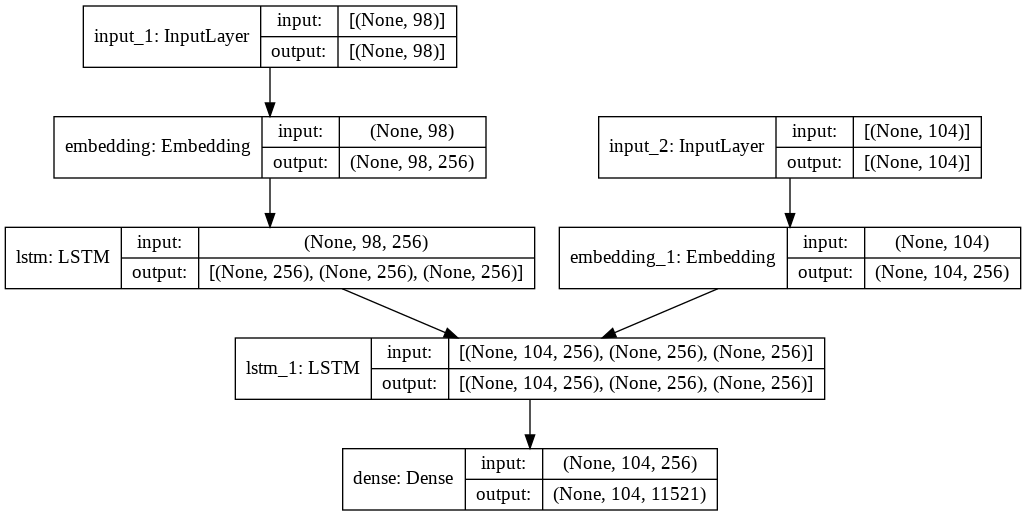

In [96]:
from tensorflow.keras.utils import plot_model
plot_model(model,show_shapes=True)

# Predict

In [97]:
def predict_model(input_sentence):
#https://stackoverflow.com/a/43749036
  input_sentence = input_sentence.replace('<start>','') #we need to remove all special characters so we will remove <start> and <end> and add it later if there is one
  input_sentence = input_sentence.replace('<end>','') #encoder inp shld contain <start> and <end> as model was trained like that
  input_sentence = preprocess_italian(input_sentence)#removes all special characters and adding <start> and <end> to the  input_sentence
  input_sentence = np.array([input_sentence])#tokenizer works on array type otherwise there will be error
  tokenizer_ip = ita_tokenizer.texts_to_sequences(input_sentence) #tokenizer
  tokenizer_ip = pad_sequences(tokenizer_ip,maxlen=italian_pad,padding='post') #padding
  encoder_embedding_op = model.layers[2](tokenizer_ip)
  encoder_op,encoder_h,encoder_c = model.layers[4](encoder_embedding_op)  #getting the op from encoder embedding
  states = [encoder_h,encoder_c]
  dec_input = np.array(eng_tokenizer.word_index['<start>']).reshape((1,1)) #index of <start>, shape = 1 row 1 column, input for decoder
  dec_op = np.array([])
  for i in range(output_length): #maximum length of output sequence
    decoder_embedding_op = model.layers[3](dec_input)
    decoder_op,decoder_h,decoder_c = model.layers[5](decoder_embedding_op,initial_state = states)
    states = [decoder_h,decoder_c]
    dense_op = model.layers[-1](decoder_op)
    op_value =np.argmax(dense_op) #finding the index with highest probability
    if op_value == eng_tokenizer.word_index['<end>']:
      break;
    dec_op = np.append(dec_op,reverse_eng_word_index[op_value]) #appending the word to a output list
    dec_input = np.array(op_value).reshape((1,1)) #the next input
  
  sentence = " ".join(j for j in dec_op) #combining the words stored in the list as a sentence
  return sentence

In [98]:
i=1
predict_model('tu pensi che tom sia ancora in australia')

'start do you think that tom is still in australia end'

In [99]:
val.italian.values[i] #italian sentence given as input

'<start> start l appartamento di tom è molto ordinato end <end>'

In [100]:
val.english.values[i] #true english translation

'<start> start tom is apartment is very tidy end <end>'

# Bleu Score

In [102]:
k = np.random.choice(range(val.shape[0]),1000)
bleu_score = []
predicted_sentence = []
for i in k:
  predict = predict_model(val.italian.values[i])
  predicted_sentence.append(predict)
  reference = val.english.values[i].replace('<start>','') #replace start and end from the text
  reference = reference.replace('<end>','').strip()
  _ = bleu.sentence_bleu([reference],predict)
  bleu_score.append(_)

bleu_score=np.array(bleu_score)
print("The average bleu score obtained is:\n%.3f"%(bleu_score.mean()))

The average bleu score obtained is:
0.908
